# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

# Todo List
- Add several dense layers after convolutional layers
- Play with learning rate and batch size

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import helper
import os

dataset_dir = 'DataSet/'

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# Import Data

In [4]:
count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl") or filename.endswith("predict.pkl") or filename.endswith("debug.pkl"):
        continue
    if filename.endswith(".pkl"): 
        df = pd.read_pickle(os.path.join(dataset_dir, filename))
        
        if count == 0:
            raw_df = df
        else:
            raw_df = raw_df.append(df, ignore_index=True)
            
        print('File: {}, DataSet Length: {}'.format(os.path.join(dataset_dir, filename), len(df)))
        count += 1
    else:
        continue
print('Total Length: {}'.format(len(raw_df)))

File: DataSet/2018-07-13_18-39-56_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-43-51_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-46-04_1.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-47-58_2.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-49-54_3.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-52-16_4.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-54-29_5.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-56-38_6.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-58-30_7.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-00-21_8.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-02-36_9.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-04-42_10.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-06-38_11.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-08-49_12.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-10-48_13.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-12-43_14.pkl, DataSet Length: 500
File: DataSet/2018-

In [6]:
data_width = len(raw_df['data'][0])

# Data Preprocessing

#### Filter out key counts less than threshold value

In [7]:
import collections
import matplotlib.pyplot as plt

key_count = collections.Counter(raw_df['key']) # List of key count in dataset

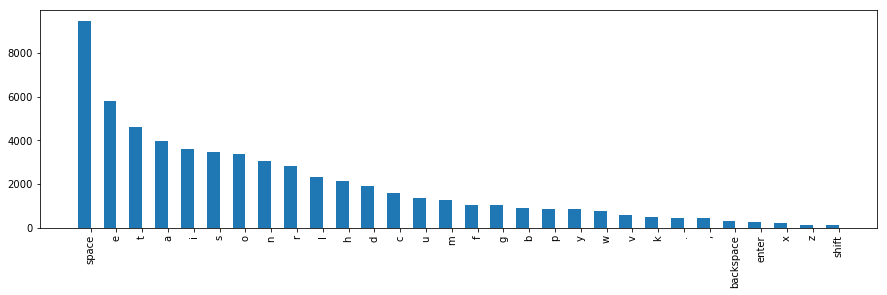

<bound method Counter.most_common of Counter({'space': 9466, 'e': 5811, 't': 4596, 'a': 3979, 'i': 3602, 's': 3452, 'o': 3392, 'n': 3049, 'r': 2832, 'l': 2343, 'h': 2164, 'd': 1916, 'c': 1583, 'u': 1368, 'm': 1293, 'f': 1070, 'g': 1050, 'b': 907, 'p': 883, 'y': 855, 'w': 788, 'v': 601, 'k': 493, '.': 464, ',': 434, 'backspace': 320, 'enter': 271, 'x': 221, 'z': 147, 'shift': 126, '-': 126, '0': 126, "'": 122, 'j': 121, 'q': 100, '2': 69, '1': 69, 'ctrl_l': 60, ';': 40, '9': 39, 'down': 38, 'delete': 38, '3': 37, '5': 31, '/': 29, 'esc': 17, 'left': 16, '8': 15, '7': 15, '6': 14, '4': 14, 'up': 10, 'right': 8, '=': 4, 'tab': 4, '`': 1})>

In [14]:
helper.plot_key_hist(key_count.most_common())
key_count.most_common

In [10]:
# Maximize DataSet Size By Finding Optimal Threshold
max_data_size, max_class_cnt, threshold_max = helper.get_optimized_threshold(key_count)
print('Max Data Size: {}, Class Count: {}, Threshold: {}'.format(max_data_size, max_class_cnt, threshold_max))

# OR, Manually define threshold
#threshold_max = 3048

Max Data Size: 25488, Class Count: 9, Threshold: 2831


#### Get Key Classes

In [ ]:
# Get list of keys with counts greater than threshold
threshold = threshold_max
min_thresh_keys = [key for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]

# Save list of key classes to pickle
pickle.dump(min_thresh_keys, open(os.path.join(dataset_dir, "key_classes.p"), "wb"))

#### Filter Data Set

In [ ]:
min_thresh_df = raw_df[raw_df['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold

In [15]:
def trim_max_thresh(grouped_class):
    return grouped_class.sample(threshold)

In [16]:
# Keep same number of samples in each class by throwing away everything past the threshold
df = min_thresh_df.groupby(['key']).apply(trim_max_thresh)

#### Plot truncated data

In [17]:
truncated_count = collections.Counter(df['key'])

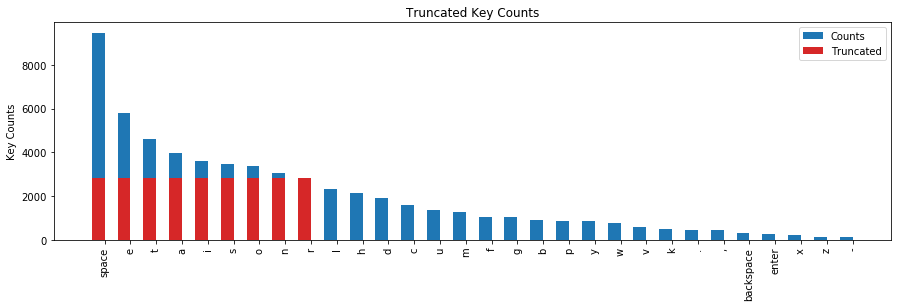

In [19]:
helper.plot_trunc_key_cnt(key_count.most_common(), truncated_count.most_common())

#### Shuffle data

In [57]:
df = df.sample(frac=1).reset_index(drop=True)

### One Hot Encode Classes
<img src="assets/one_hot_encoding.jpg" style="width: 200px;"/>

In [58]:
n_classes = len(set(df['key']))

labels_str = [str(key) for key in df['key']]
lb = preprocessing.LabelBinarizer() # Create encoder
lb.fit(list(set(labels_str)))
labels = lb.transform(labels_str)

In [59]:
lb.classes_

array(['a', 'e', 'i', 'n', 'o', 'r', 's', 'space', 't'],
      dtype='<U5')

In [60]:
# Save label set
pickle.dump(lb.classes_, open(os.path.join(dataset_dir, 'labels.p'), "wb"))

### Cross Validation: Training, Validation, and Test Sets

In [61]:
input_data = df['data'].values
input_data = np.stack(input_data, axis=0)

In [62]:
from sklearn.model_selection import train_test_split
train_features, temp_features, train_labels, temp_labels = train_test_split(input_data, labels, test_size=0.1, random_state=42)
test_features, valid_features, test_labels, valid_labels = train_test_split(temp_features, temp_labels, test_size=0.5, random_state=42)

### Normalize Data
Normalization should be performed on the training set. All other test sets should be normalized to parameters fit from the training set's scaler.

#### Normalize Training Set and Fit Scaler

In [63]:
"""
Careful with MinMaxScaler. 
You specifically wan't to use the fit then transform or fit_transform function on the training set only.
On any of the test cross validation sets or prediction data, you DON'T want to fit() or fit_transform().
This would reset the fit of the scaler that we fit with the training set data.
Use the transform() function on the test sets.
"""
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(train_features) # Compute the minimum and maximum to be used for later scaling.
#train_features = scaler.fit_transform(train_features)
train_features = scaler.transform(train_features)

C:\Users\stephen\AppData\Local\conda\conda\envs\tfgpu1.1\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [64]:
train_features.shape

(22931, 10240)

In [65]:
# Reshape for 1 channel of audio data
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
# labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
train_features.shape

(22931, 10240, 1)

In [66]:
# Save scaler for later scaling on test sets. scaler.fit() saved the min max values
pickle.dump(scaler, open(os.path.join(dataset_dir, 'scaler.p'), "wb"))

#### Normalize Validation Set

In [67]:
valid_features = scaler.transform(valid_features) # Don't use fit_transform() on test sets, use transform()

# Reshape for 1 channel of audio data
valid_features = valid_features.reshape((valid_features.shape[0], valid_features.shape[1], 1))

# Define Network

### Input

In [68]:
def model_inputs(data_width, n_classes):
    """
    Create the model inputs
    :param data_width: The total number of samples in the recorded data point
    :param n_classes: Number of Classes
    :return: Tuple of (tensor of input audio data, key press labels, learning rate, keep_prob)
    """
    # TODO: Add audio channels to input
    
    with tf.name_scope("Inputs"):
        audio_inputs = tf.placeholder(tf.float32, [None, data_width, 1], name='inputs')
    with tf.name_scope("Targets"):
        key_labels = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_probability')

    return audio_inputs, key_labels, learning_rate, keep_prob

### Get Batches

In [69]:
def get_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

### Network

In [70]:
def network(X, keep_prob, n_classes):
    """
    Create the network
    :param X: Tensor of input recording(s)
    :param keep_prob: Tensor for the keep probability
    :param n_classes: Number of Classes
    :return: Tuple of (tensor output of the classifier, tensor logits of the classifier)
    """    
    # Hyperparameters
    alpha = 0.2
    h_dim = 32
    
    #print("X: {}".format(X.shape))
     
    with tf.name_scope("Hidden_Layer1"):
        #h1 = tf.layers.dense(X, h_dim, activation=None)
        h1 = tf.layers.conv1d(X, h_dim, 200, 10, 'same', activation=None)
        h1 = tf.layers.max_pooling1d(h1, 5, 2, 'same')
        h1 = tf.nn.dropout(h1, keep_prob) # Regularization
        h1 = tf.maximum(h1*alpha, h1) # Leaky ReLu
        h1 = tf.layers.batch_normalization(h1)
        
    #print("h1: {}".format(h1.shape))

    with tf.name_scope("Hidden_Layer2"):
        #h2 = tf.layers.dense(h1, h_dim, activation=None)
        h2 = tf.layers.conv1d(h1, h_dim*2, 50, 5, 'same', activation=None)
        #h2 = tf.layers.maxpool2d(h2, 5, 2, 'same')
        h2 = tf.nn.dropout(h2, keep_prob) # Regularization        
        h2 = tf.maximum(h2*alpha, h2) # Leaky ReLu
        h2 = tf.layers.batch_normalization(h2)
        
    #print("h2: {}".format(h2.shape))

    with tf.name_scope("Hidden_Layer3"):
        #h3 = tf.layers.dense(h2, h_dim, activation=None)
        h3 = tf.layers.conv1d(h2, h_dim*3, 20, 2, 'same', activation=None)
        #h3 = tf.layers.maxpool2d(h3, 3, 2, 'same')
        h3 = tf.nn.dropout(h3, keep_prob) # Regularization
        h3 = tf.maximum(h3*alpha, h3) # Leaky ReLu
        h3 = tf.layers.batch_normalization(h3)
        
    with tf.name_scope("Hidden_Layer4"):
        h4 = tf.layers.conv1d(h3, h_dim*4, 10, 1, 'same', activation=None)
        h4 = tf.nn.dropout(h4, keep_prob) # Regularization
        h4 = tf.maximum(h4*alpha, h4) # Leaky ReLu
        h4 = tf.layers.batch_normalization(h4)
    
    
    
    with tf.name_scope("Output"):
        flat_dim = int(h4.get_shape()[1])*int(h4.get_shape()[2])
        flat = tf.reshape(h4, [-1, flat_dim])
        #print("flat: {}".format(flat.shape))
        logits = tf.layers.dense(flat, n_classes, activation=None, name='logits')
        #print("logits: {}".format(logits.shape))
        #out = tf.nn.softmax(logits, name='softmax_out')

    return logits

### Show Stats

In [71]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, esi):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    : esi: Epochs since the last improvement
    """
    with tf.name_scope("Validation_Stats"):
        valid_trunc_len = min(1000, len(valid_features))
        train_trunc_len = min(1000, len(train_features))
        
        validation_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
        validation_accuracy = session.run(accuracy, feed_dict={x: valid_features[:valid_trunc_len], y: valid_labels[:valid_trunc_len], keep_prob: 1.0})
        train_accuracy = session.run(accuracy, feed_dict={x: train_features[:train_trunc_len], y: train_labels[:train_trunc_len], keep_prob: 1.0})
        print("Train Accuracy: {0:0.4f}, Validation Accuracy: {1:0.4f}, Validation Loss: {2:0.4f}, ESI: {3}".format(train_accuracy, validation_accuracy, validation_loss, esi))
        return validation_accuracy

### Build Neural Network

In [72]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x, y, learn_rate, keep_prob = model_inputs(data_width, n_classes)

#Model
logits = network(x, keep_prob, n_classes)

with tf.name_scope("Cost"):
    # Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss'), name='cost')
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learn_rate, name='optimizer').minimize(cost)

with tf.name_scope("Accuracy"):
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name='prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
predicted = tf.nn.softmax(logits, name='predicted')

### Write out the graph for TensorBoard

In [73]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/2', sess.graph)

### Hyperparameters

In [74]:
epochs = 5000
batch_size = 16
keep_probability = 0.40
learning_rate = 0.0001

# Train Neural Network

In [75]:
# Accuracy to beat (Min of 3 classes)
print("{:.3}%".format((1/n_classes)*100))

11.1%


In [76]:
max_validation_accuracy = 0.0
epochs_since_improvement = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_features, batch_labels in get_batches(train_features, train_labels, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, 
                                           y: batch_labels, 
                                           learn_rate: learning_rate, 
                                           keep_prob: keep_probability})
        if epoch % 1 == 0:
            print('Epoch {}: '.format(epoch), end='')
            validation_accuracy = print_stats(sess, batch_features, batch_labels, cost, accuracy, epochs_since_improvement)         
        
            if validation_accuracy > max_validation_accuracy:
                max_validation_accuracy = validation_accuracy
                epochs_since_improvement = 0
                saver.save(sess, "checkpoints/model.ckpt")
            else:
                epochs_since_improvement += 1

Epoch 0: Train Accuracy: 0.1170, Validation Accuracy: 0.1100, Validation Loss: 2.2001, ESI: 0
Epoch 1: Train Accuracy: 0.1100, Validation Accuracy: 0.1200, Validation Loss: 2.2029, ESI: 0
Epoch 2: Train Accuracy: 0.1270, Validation Accuracy: 0.1110, Validation Loss: 2.2047, ESI: 0
Epoch 3: Train Accuracy: 0.1160, Validation Accuracy: 0.1010, Validation Loss: 2.2017, ESI: 1
Epoch 4: Train Accuracy: 0.0920, Validation Accuracy: 0.1020, Validation Loss: 2.2054, ESI: 2
Epoch 5: Train Accuracy: 0.0920, Validation Accuracy: 0.1020, Validation Loss: 2.1960, ESI: 3
Epoch 6: Train Accuracy: 0.0920, Validation Accuracy: 0.1020, Validation Loss: 2.2006, ESI: 4
Epoch 7: Train Accuracy: 0.0930, Validation Accuracy: 0.1010, Validation Loss: 2.1956, ESI: 5
Epoch 8: Train Accuracy: 0.0920, Validation Accuracy: 0.1020, Validation Loss: 2.1976, ESI: 6
Epoch 9: Train Accuracy: 0.1200, Validation Accuracy: 0.1160, Validation Loss: 2.1949, ESI: 7
Epoch 10: Train Accuracy: 0.1160, Validation Accuracy: 0.101

Epoch 87: Train Accuracy: 0.5020, Validation Accuracy: 0.4650, Validation Loss: 0.4850, ESI: 2
Epoch 88: Train Accuracy: 0.5070, Validation Accuracy: 0.4830, Validation Loss: 0.5535, ESI: 3
Epoch 89: Train Accuracy: 0.4920, Validation Accuracy: 0.4690, Validation Loss: 0.3931, ESI: 0
Epoch 90: Train Accuracy: 0.5090, Validation Accuracy: 0.4780, Validation Loss: 0.4328, ESI: 1
Epoch 91: Train Accuracy: 0.5040, Validation Accuracy: 0.4720, Validation Loss: 0.4490, ESI: 2
Epoch 92: Train Accuracy: 0.5120, Validation Accuracy: 0.4810, Validation Loss: 0.4404, ESI: 3
Epoch 93: Train Accuracy: 0.5000, Validation Accuracy: 0.4770, Validation Loss: 0.3720, ESI: 4
Epoch 94: Train Accuracy: 0.5230, Validation Accuracy: 0.4810, Validation Loss: 0.3991, ESI: 5
Epoch 95: Train Accuracy: 0.5150, Validation Accuracy: 0.4630, Validation Loss: 0.3417, ESI: 6
Epoch 96: Train Accuracy: 0.5210, Validation Accuracy: 0.4880, Validation Loss: 0.3921, ESI: 7
Epoch 97: Train Accuracy: 0.5040, Validation Accur

Epoch 173: Train Accuracy: 0.5990, Validation Accuracy: 0.5380, Validation Loss: 0.3601, ESI: 0
Epoch 174: Train Accuracy: 0.5920, Validation Accuracy: 0.5420, Validation Loss: 0.3619, ESI: 1
Epoch 175: Train Accuracy: 0.5980, Validation Accuracy: 0.5350, Validation Loss: 0.3651, ESI: 2
Epoch 176: Train Accuracy: 0.5920, Validation Accuracy: 0.5490, Validation Loss: 0.3150, ESI: 3
Epoch 177: Train Accuracy: 0.5990, Validation Accuracy: 0.5430, Validation Loss: 0.3659, ESI: 0
Epoch 178: Train Accuracy: 0.5960, Validation Accuracy: 0.5490, Validation Loss: 0.3012, ESI: 1
Epoch 179: Train Accuracy: 0.6000, Validation Accuracy: 0.5420, Validation Loss: 0.3519, ESI: 0
Epoch 180: Train Accuracy: 0.6010, Validation Accuracy: 0.5480, Validation Loss: 0.3448, ESI: 1
Epoch 181: Train Accuracy: 0.6000, Validation Accuracy: 0.5380, Validation Loss: 0.3302, ESI: 2
Epoch 182: Train Accuracy: 0.6050, Validation Accuracy: 0.5450, Validation Loss: 0.3882, ESI: 3
Epoch 183: Train Accuracy: 0.6040, Valid

Epoch 258: Train Accuracy: 0.6320, Validation Accuracy: 0.5680, Validation Loss: 0.2870, ESI: 39
Epoch 259: Train Accuracy: 0.6290, Validation Accuracy: 0.5690, Validation Loss: 0.2599, ESI: 40
Epoch 260: Train Accuracy: 0.6220, Validation Accuracy: 0.5540, Validation Loss: 0.2871, ESI: 41
Epoch 261: Train Accuracy: 0.6250, Validation Accuracy: 0.5710, Validation Loss: 0.2893, ESI: 42
Epoch 262: Train Accuracy: 0.6300, Validation Accuracy: 0.5740, Validation Loss: 0.2560, ESI: 0
Epoch 263: Train Accuracy: 0.6320, Validation Accuracy: 0.5630, Validation Loss: 0.2994, ESI: 0
Epoch 264: Train Accuracy: 0.6260, Validation Accuracy: 0.5630, Validation Loss: 0.2387, ESI: 1
Epoch 265: Train Accuracy: 0.6370, Validation Accuracy: 0.5640, Validation Loss: 0.2561, ESI: 2
Epoch 266: Train Accuracy: 0.6390, Validation Accuracy: 0.5780, Validation Loss: 0.2568, ESI: 3
Epoch 267: Train Accuracy: 0.6220, Validation Accuracy: 0.5490, Validation Loss: 0.3044, ESI: 0
Epoch 268: Train Accuracy: 0.6310, V

Epoch 344: Train Accuracy: 0.6400, Validation Accuracy: 0.5820, Validation Loss: 0.2570, ESI: 1
Epoch 345: Train Accuracy: 0.6350, Validation Accuracy: 0.5860, Validation Loss: 0.2503, ESI: 2
Epoch 346: Train Accuracy: 0.6500, Validation Accuracy: 0.5890, Validation Loss: 0.2856, ESI: 3
Epoch 347: Train Accuracy: 0.6520, Validation Accuracy: 0.5850, Validation Loss: 0.2978, ESI: 4
Epoch 348: Train Accuracy: 0.6380, Validation Accuracy: 0.5860, Validation Loss: 0.2652, ESI: 5
Epoch 349: Train Accuracy: 0.6410, Validation Accuracy: 0.5840, Validation Loss: 0.2921, ESI: 6
Epoch 350: Train Accuracy: 0.6440, Validation Accuracy: 0.5880, Validation Loss: 0.2328, ESI: 7
Epoch 351: Train Accuracy: 0.6380, Validation Accuracy: 0.5880, Validation Loss: 0.2384, ESI: 8
Epoch 352: Train Accuracy: 0.6360, Validation Accuracy: 0.5810, Validation Loss: 0.2799, ESI: 9
Epoch 353: Train Accuracy: 0.6460, Validation Accuracy: 0.5850, Validation Loss: 0.3406, ESI: 10
Epoch 354: Train Accuracy: 0.6490, Vali

Epoch 514: Train Accuracy: 0.6650, Validation Accuracy: 0.6010, Validation Loss: 0.1878, ESI: 68
Epoch 515: Train Accuracy: 0.6620, Validation Accuracy: 0.5970, Validation Loss: 0.1899, ESI: 69
Epoch 516: Train Accuracy: 0.6720, Validation Accuracy: 0.5980, Validation Loss: 0.1956, ESI: 70
Epoch 517: Train Accuracy: 0.6780, Validation Accuracy: 0.6040, Validation Loss: 0.2017, ESI: 71
Epoch 518: Train Accuracy: 0.6650, Validation Accuracy: 0.6060, Validation Loss: 0.2044, ESI: 72
Epoch 519: Train Accuracy: 0.6710, Validation Accuracy: 0.6010, Validation Loss: 0.2443, ESI: 73
Epoch 520: Train Accuracy: 0.6750, Validation Accuracy: 0.6120, Validation Loss: 0.2449, ESI: 74
Epoch 521: Train Accuracy: 0.6670, Validation Accuracy: 0.6000, Validation Loss: 0.2095, ESI: 75
Epoch 522: Train Accuracy: 0.6720, Validation Accuracy: 0.6030, Validation Loss: 0.2492, ESI: 76
Epoch 523: Train Accuracy: 0.6660, Validation Accuracy: 0.6010, Validation Loss: 0.2348, ESI: 77
Epoch 524: Train Accuracy: 0.6

Epoch 599: Train Accuracy: 0.6800, Validation Accuracy: 0.6110, Validation Loss: 0.2341, ESI: 19
Epoch 600: Train Accuracy: 0.6650, Validation Accuracy: 0.6020, Validation Loss: 0.2478, ESI: 20
Epoch 601: Train Accuracy: 0.6800, Validation Accuracy: 0.6090, Validation Loss: 0.1812, ESI: 21
Epoch 602: Train Accuracy: 0.6820, Validation Accuracy: 0.6100, Validation Loss: 0.2230, ESI: 22
Epoch 603: Train Accuracy: 0.6840, Validation Accuracy: 0.6020, Validation Loss: 0.2576, ESI: 23
Epoch 604: Train Accuracy: 0.6780, Validation Accuracy: 0.6060, Validation Loss: 0.2395, ESI: 24
Epoch 605: Train Accuracy: 0.6820, Validation Accuracy: 0.6010, Validation Loss: 0.2187, ESI: 25
Epoch 606: Train Accuracy: 0.6760, Validation Accuracy: 0.6110, Validation Loss: 0.2234, ESI: 26
Epoch 607: Train Accuracy: 0.6780, Validation Accuracy: 0.6080, Validation Loss: 0.2414, ESI: 27
Epoch 608: Train Accuracy: 0.6770, Validation Accuracy: 0.6110, Validation Loss: 0.2187, ESI: 28
Epoch 609: Train Accuracy: 0.6

Epoch 684: Train Accuracy: 0.6780, Validation Accuracy: 0.6150, Validation Loss: 0.1638, ESI: 31
Epoch 685: Train Accuracy: 0.6880, Validation Accuracy: 0.6070, Validation Loss: 0.2099, ESI: 32
Epoch 686: Train Accuracy: 0.6900, Validation Accuracy: 0.6130, Validation Loss: 0.2083, ESI: 33
Epoch 687: Train Accuracy: 0.6990, Validation Accuracy: 0.6220, Validation Loss: 0.2117, ESI: 34
Epoch 688: Train Accuracy: 0.6940, Validation Accuracy: 0.6140, Validation Loss: 0.2103, ESI: 35
Epoch 689: Train Accuracy: 0.6750, Validation Accuracy: 0.6100, Validation Loss: 0.2305, ESI: 36
Epoch 690: Train Accuracy: 0.6930, Validation Accuracy: 0.6160, Validation Loss: 0.1991, ESI: 37
Epoch 691: Train Accuracy: 0.6870, Validation Accuracy: 0.6140, Validation Loss: 0.2103, ESI: 38
Epoch 692: Train Accuracy: 0.6860, Validation Accuracy: 0.6160, Validation Loss: 0.1739, ESI: 39
Epoch 693: Train Accuracy: 0.6820, Validation Accuracy: 0.6070, Validation Loss: 0.1793, ESI: 40
Epoch 694: Train Accuracy: 0.6

Epoch 769: Train Accuracy: 0.6900, Validation Accuracy: 0.6220, Validation Loss: 0.2434, ESI: 6
Epoch 770: Train Accuracy: 0.6900, Validation Accuracy: 0.6350, Validation Loss: 0.2363, ESI: 7
Epoch 771: Train Accuracy: 0.6960, Validation Accuracy: 0.6210, Validation Loss: 0.2017, ESI: 0
Epoch 772: Train Accuracy: 0.6810, Validation Accuracy: 0.6340, Validation Loss: 0.1950, ESI: 1
Epoch 773: Train Accuracy: 0.6970, Validation Accuracy: 0.6330, Validation Loss: 0.2123, ESI: 2
Epoch 774: Train Accuracy: 0.6880, Validation Accuracy: 0.6220, Validation Loss: 0.2374, ESI: 3
Epoch 775: Train Accuracy: 0.6900, Validation Accuracy: 0.6220, Validation Loss: 0.1693, ESI: 4
Epoch 776: Train Accuracy: 0.6830, Validation Accuracy: 0.6200, Validation Loss: 0.2190, ESI: 5
Epoch 777: Train Accuracy: 0.6850, Validation Accuracy: 0.6300, Validation Loss: 0.2022, ESI: 6
Epoch 778: Train Accuracy: 0.6850, Validation Accuracy: 0.6310, Validation Loss: 0.2328, ESI: 7
Epoch 779: Train Accuracy: 0.7000, Valid

Epoch 854: Train Accuracy: 0.6870, Validation Accuracy: 0.6340, Validation Loss: 0.2105, ESI: 1
Epoch 855: Train Accuracy: 0.6880, Validation Accuracy: 0.6220, Validation Loss: 0.1808, ESI: 2
Epoch 856: Train Accuracy: 0.6940, Validation Accuracy: 0.6400, Validation Loss: 0.1810, ESI: 3
Epoch 857: Train Accuracy: 0.6860, Validation Accuracy: 0.6180, Validation Loss: 0.2388, ESI: 4
Epoch 858: Train Accuracy: 0.6970, Validation Accuracy: 0.6350, Validation Loss: 0.2043, ESI: 5
Epoch 859: Train Accuracy: 0.6890, Validation Accuracy: 0.6150, Validation Loss: 0.1611, ESI: 6
Epoch 860: Train Accuracy: 0.6990, Validation Accuracy: 0.6250, Validation Loss: 0.1900, ESI: 7
Epoch 861: Train Accuracy: 0.6970, Validation Accuracy: 0.6390, Validation Loss: 0.1885, ESI: 8
Epoch 862: Train Accuracy: 0.6930, Validation Accuracy: 0.6320, Validation Loss: 0.2195, ESI: 9
Epoch 863: Train Accuracy: 0.6900, Validation Accuracy: 0.6260, Validation Loss: 0.2160, ESI: 10
Epoch 864: Train Accuracy: 0.6920, Vali

Epoch 939: Train Accuracy: 0.6980, Validation Accuracy: 0.6340, Validation Loss: 0.1984, ESI: 17
Epoch 940: Train Accuracy: 0.6880, Validation Accuracy: 0.6280, Validation Loss: 0.1888, ESI: 18
Epoch 941: Train Accuracy: 0.6990, Validation Accuracy: 0.6250, Validation Loss: 0.2109, ESI: 19
Epoch 942: Train Accuracy: 0.7010, Validation Accuracy: 0.6340, Validation Loss: 0.2206, ESI: 20
Epoch 943: Train Accuracy: 0.7040, Validation Accuracy: 0.6370, Validation Loss: 0.1946, ESI: 21
Epoch 944: Train Accuracy: 0.7070, Validation Accuracy: 0.6370, Validation Loss: 0.1732, ESI: 22
Epoch 945: Train Accuracy: 0.6930, Validation Accuracy: 0.6220, Validation Loss: 0.2040, ESI: 23
Epoch 946: Train Accuracy: 0.7020, Validation Accuracy: 0.6440, Validation Loss: 0.1757, ESI: 24
Epoch 947: Train Accuracy: 0.6930, Validation Accuracy: 0.6340, Validation Loss: 0.1462, ESI: 0
Epoch 948: Train Accuracy: 0.6910, Validation Accuracy: 0.6340, Validation Loss: 0.1829, ESI: 1
Epoch 949: Train Accuracy: 0.691

Epoch 1024: Train Accuracy: 0.6980, Validation Accuracy: 0.6310, Validation Loss: 0.1869, ESI: 77
Epoch 1025: Train Accuracy: 0.6970, Validation Accuracy: 0.6370, Validation Loss: 0.1663, ESI: 78
Epoch 1026: Train Accuracy: 0.6990, Validation Accuracy: 0.6310, Validation Loss: 0.1982, ESI: 79
Epoch 1027: Train Accuracy: 0.7030, Validation Accuracy: 0.6310, Validation Loss: 0.2200, ESI: 80
Epoch 1028: Train Accuracy: 0.6950, Validation Accuracy: 0.6310, Validation Loss: 0.1784, ESI: 81
Epoch 1029: Train Accuracy: 0.7110, Validation Accuracy: 0.6350, Validation Loss: 0.1827, ESI: 82
Epoch 1030: Train Accuracy: 0.7050, Validation Accuracy: 0.6320, Validation Loss: 0.2141, ESI: 83
Epoch 1031: Train Accuracy: 0.6960, Validation Accuracy: 0.6270, Validation Loss: 0.2047, ESI: 84
Epoch 1032: Train Accuracy: 0.7060, Validation Accuracy: 0.6430, Validation Loss: 0.2196, ESI: 85
Epoch 1033: Train Accuracy: 0.6990, Validation Accuracy: 0.6330, Validation Loss: 0.2008, ESI: 86
Epoch 1034: Train Ac

Epoch 1108: Train Accuracy: 0.6960, Validation Accuracy: 0.6410, Validation Loss: 0.2112, ESI: 71
Epoch 1109: Train Accuracy: 0.7020, Validation Accuracy: 0.6410, Validation Loss: 0.2201, ESI: 72
Epoch 1110: Train Accuracy: 0.7090, Validation Accuracy: 0.6470, Validation Loss: 0.2166, ESI: 73
Epoch 1111: Train Accuracy: 0.7090, Validation Accuracy: 0.6410, Validation Loss: 0.2227, ESI: 0
Epoch 1112: Train Accuracy: 0.7060, Validation Accuracy: 0.6400, Validation Loss: 0.2031, ESI: 1
Epoch 1113: Train Accuracy: 0.7120, Validation Accuracy: 0.6340, Validation Loss: 0.1926, ESI: 2
Epoch 1114: Train Accuracy: 0.7010, Validation Accuracy: 0.6380, Validation Loss: 0.2586, ESI: 3
Epoch 1115: Train Accuracy: 0.7040, Validation Accuracy: 0.6260, Validation Loss: 0.2165, ESI: 4
Epoch 1116: Train Accuracy: 0.7000, Validation Accuracy: 0.6350, Validation Loss: 0.2645, ESI: 5
Epoch 1117: Train Accuracy: 0.7010, Validation Accuracy: 0.6470, Validation Loss: 0.2291, ESI: 6
Epoch 1118: Train Accuracy:

Epoch 1192: Train Accuracy: 0.7000, Validation Accuracy: 0.6460, Validation Loss: 0.1910, ESI: 5
Epoch 1193: Train Accuracy: 0.7010, Validation Accuracy: 0.6260, Validation Loss: 0.2388, ESI: 6
Epoch 1194: Train Accuracy: 0.7000, Validation Accuracy: 0.6410, Validation Loss: 0.1697, ESI: 7
Epoch 1195: Train Accuracy: 0.7050, Validation Accuracy: 0.6420, Validation Loss: 0.1712, ESI: 8
Epoch 1196: Train Accuracy: 0.6970, Validation Accuracy: 0.6410, Validation Loss: 0.2173, ESI: 9
Epoch 1197: Train Accuracy: 0.7100, Validation Accuracy: 0.6470, Validation Loss: 0.1547, ESI: 10
Epoch 1198: Train Accuracy: 0.7050, Validation Accuracy: 0.6410, Validation Loss: 0.1711, ESI: 11
Epoch 1199: Train Accuracy: 0.7020, Validation Accuracy: 0.6440, Validation Loss: 0.1682, ESI: 12
Epoch 1200: Train Accuracy: 0.7150, Validation Accuracy: 0.6420, Validation Loss: 0.2281, ESI: 13
Epoch 1201: Train Accuracy: 0.7050, Validation Accuracy: 0.6440, Validation Loss: 0.1719, ESI: 14
Epoch 1202: Train Accurac

Epoch 1276: Train Accuracy: 0.7040, Validation Accuracy: 0.6440, Validation Loss: 0.1969, ESI: 89
Epoch 1277: Train Accuracy: 0.7040, Validation Accuracy: 0.6400, Validation Loss: 0.2090, ESI: 90
Epoch 1278: Train Accuracy: 0.7050, Validation Accuracy: 0.6460, Validation Loss: 0.2022, ESI: 91
Epoch 1279: Train Accuracy: 0.7070, Validation Accuracy: 0.6320, Validation Loss: 0.1912, ESI: 92
Epoch 1280: Train Accuracy: 0.7130, Validation Accuracy: 0.6410, Validation Loss: 0.2220, ESI: 93
Epoch 1281: Train Accuracy: 0.7090, Validation Accuracy: 0.6440, Validation Loss: 0.2328, ESI: 94
Epoch 1282: Train Accuracy: 0.7080, Validation Accuracy: 0.6400, Validation Loss: 0.2011, ESI: 95
Epoch 1283: Train Accuracy: 0.7070, Validation Accuracy: 0.6360, Validation Loss: 0.2187, ESI: 96
Epoch 1284: Train Accuracy: 0.7090, Validation Accuracy: 0.6430, Validation Loss: 0.1926, ESI: 97
Epoch 1285: Train Accuracy: 0.7130, Validation Accuracy: 0.6320, Validation Loss: 0.2450, ESI: 98
Epoch 1286: Train Ac

Epoch 1359: Train Accuracy: 0.7150, Validation Accuracy: 0.6480, Validation Loss: 0.1577, ESI: 172
Epoch 1360: Train Accuracy: 0.7040, Validation Accuracy: 0.6470, Validation Loss: 0.1463, ESI: 173
Epoch 1361: Train Accuracy: 0.7220, Validation Accuracy: 0.6450, Validation Loss: 0.2142, ESI: 174
Epoch 1362: Train Accuracy: 0.7170, Validation Accuracy: 0.6390, Validation Loss: 0.2020, ESI: 175
Epoch 1363: Train Accuracy: 0.7200, Validation Accuracy: 0.6380, Validation Loss: 0.2054, ESI: 176
Epoch 1364: Train Accuracy: 0.7160, Validation Accuracy: 0.6340, Validation Loss: 0.1757, ESI: 177
Epoch 1365: Train Accuracy: 0.7100, Validation Accuracy: 0.6340, Validation Loss: 0.2102, ESI: 178
Epoch 1366: Train Accuracy: 0.7090, Validation Accuracy: 0.6360, Validation Loss: 0.1586, ESI: 179
Epoch 1367: Train Accuracy: 0.7170, Validation Accuracy: 0.6470, Validation Loss: 0.1564, ESI: 180
Epoch 1368: Train Accuracy: 0.7140, Validation Accuracy: 0.6540, Validation Loss: 0.1596, ESI: 181
Epoch 1369

Epoch 1443: Train Accuracy: 0.7230, Validation Accuracy: 0.6430, Validation Loss: 0.1596, ESI: 74
Epoch 1444: Train Accuracy: 0.7150, Validation Accuracy: 0.6420, Validation Loss: 0.1745, ESI: 75
Epoch 1445: Train Accuracy: 0.7260, Validation Accuracy: 0.6400, Validation Loss: 0.1664, ESI: 76
Epoch 1446: Train Accuracy: 0.7200, Validation Accuracy: 0.6410, Validation Loss: 0.1934, ESI: 77
Epoch 1447: Train Accuracy: 0.7200, Validation Accuracy: 0.6440, Validation Loss: 0.1738, ESI: 78
Epoch 1448: Train Accuracy: 0.7190, Validation Accuracy: 0.6560, Validation Loss: 0.1663, ESI: 79
Epoch 1449: Train Accuracy: 0.7100, Validation Accuracy: 0.6400, Validation Loss: 0.1898, ESI: 0
Epoch 1450: Train Accuracy: 0.7100, Validation Accuracy: 0.6470, Validation Loss: 0.1674, ESI: 1
Epoch 1451: Train Accuracy: 0.7180, Validation Accuracy: 0.6390, Validation Loss: 0.1923, ESI: 2
Epoch 1452: Train Accuracy: 0.7260, Validation Accuracy: 0.6470, Validation Loss: 0.1783, ESI: 3
Epoch 1453: Train Accura

Epoch 1527: Train Accuracy: 0.7220, Validation Accuracy: 0.6400, Validation Loss: 0.2299, ESI: 28
Epoch 1528: Train Accuracy: 0.7170, Validation Accuracy: 0.6380, Validation Loss: 0.1843, ESI: 29
Epoch 1529: Train Accuracy: 0.7210, Validation Accuracy: 0.6410, Validation Loss: 0.1855, ESI: 30
Epoch 1530: Train Accuracy: 0.7350, Validation Accuracy: 0.6410, Validation Loss: 0.1801, ESI: 31
Epoch 1531: Train Accuracy: 0.7180, Validation Accuracy: 0.6380, Validation Loss: 0.2311, ESI: 32
Epoch 1532: Train Accuracy: 0.7290, Validation Accuracy: 0.6470, Validation Loss: 0.2157, ESI: 33
Epoch 1533: Train Accuracy: 0.7140, Validation Accuracy: 0.6480, Validation Loss: 0.1955, ESI: 34
Epoch 1534: Train Accuracy: 0.7270, Validation Accuracy: 0.6440, Validation Loss: 0.2617, ESI: 35
Epoch 1535: Train Accuracy: 0.7200, Validation Accuracy: 0.6450, Validation Loss: 0.1866, ESI: 36
Epoch 1536: Train Accuracy: 0.7210, Validation Accuracy: 0.6440, Validation Loss: 0.2071, ESI: 37
Epoch 1537: Train Ac

Epoch 1611: Train Accuracy: 0.7180, Validation Accuracy: 0.6510, Validation Loss: 0.1978, ESI: 112
Epoch 1612: Train Accuracy: 0.7230, Validation Accuracy: 0.6470, Validation Loss: 0.2214, ESI: 113
Epoch 1613: Train Accuracy: 0.7280, Validation Accuracy: 0.6340, Validation Loss: 0.2260, ESI: 114
Epoch 1614: Train Accuracy: 0.7180, Validation Accuracy: 0.6390, Validation Loss: 0.1704, ESI: 115
Epoch 1615: Train Accuracy: 0.7320, Validation Accuracy: 0.6440, Validation Loss: 0.2076, ESI: 116
Epoch 1616: Train Accuracy: 0.7340, Validation Accuracy: 0.6450, Validation Loss: 0.1815, ESI: 117
Epoch 1617: Train Accuracy: 0.7220, Validation Accuracy: 0.6470, Validation Loss: 0.1782, ESI: 118
Epoch 1618: Train Accuracy: 0.7180, Validation Accuracy: 0.6480, Validation Loss: 0.1889, ESI: 119
Epoch 1619: Train Accuracy: 0.7230, Validation Accuracy: 0.6510, Validation Loss: 0.1622, ESI: 120
Epoch 1620: Train Accuracy: 0.7310, Validation Accuracy: 0.6470, Validation Loss: 0.1829, ESI: 121
Epoch 1621

Epoch 1694: Train Accuracy: 0.7360, Validation Accuracy: 0.6430, Validation Loss: 0.1813, ESI: 195
Epoch 1695: Train Accuracy: 0.7190, Validation Accuracy: 0.6420, Validation Loss: 0.1344, ESI: 196
Epoch 1696: Train Accuracy: 0.7330, Validation Accuracy: 0.6430, Validation Loss: 0.1763, ESI: 197
Epoch 1697: Train Accuracy: 0.7330, Validation Accuracy: 0.6420, Validation Loss: 0.2049, ESI: 198
Epoch 1698: Train Accuracy: 0.7330, Validation Accuracy: 0.6430, Validation Loss: 0.2114, ESI: 199
Epoch 1699: Train Accuracy: 0.7330, Validation Accuracy: 0.6440, Validation Loss: 0.1750, ESI: 200
Epoch 1700: Train Accuracy: 0.7440, Validation Accuracy: 0.6540, Validation Loss: 0.1820, ESI: 201
Epoch 1701: Train Accuracy: 0.7220, Validation Accuracy: 0.6430, Validation Loss: 0.1635, ESI: 202
Epoch 1702: Train Accuracy: 0.7280, Validation Accuracy: 0.6490, Validation Loss: 0.1912, ESI: 203
Epoch 1703: Train Accuracy: 0.7300, Validation Accuracy: 0.6420, Validation Loss: 0.1747, ESI: 204
Epoch 1704

Epoch 1778: Train Accuracy: 0.7280, Validation Accuracy: 0.6420, Validation Loss: 0.1727, ESI: 32
Epoch 1779: Train Accuracy: 0.7300, Validation Accuracy: 0.6550, Validation Loss: 0.1851, ESI: 33
Epoch 1780: Train Accuracy: 0.7300, Validation Accuracy: 0.6530, Validation Loss: 0.1803, ESI: 34
Epoch 1781: Train Accuracy: 0.7270, Validation Accuracy: 0.6530, Validation Loss: 0.1858, ESI: 35
Epoch 1782: Train Accuracy: 0.7240, Validation Accuracy: 0.6470, Validation Loss: 0.1674, ESI: 36
Epoch 1783: Train Accuracy: 0.7280, Validation Accuracy: 0.6490, Validation Loss: 0.2028, ESI: 37
Epoch 1784: Train Accuracy: 0.7190, Validation Accuracy: 0.6540, Validation Loss: 0.1888, ESI: 38
Epoch 1785: Train Accuracy: 0.7270, Validation Accuracy: 0.6540, Validation Loss: 0.1961, ESI: 39
Epoch 1786: Train Accuracy: 0.7240, Validation Accuracy: 0.6530, Validation Loss: 0.1794, ESI: 40
Epoch 1787: Train Accuracy: 0.7340, Validation Accuracy: 0.6460, Validation Loss: 0.1970, ESI: 41
Epoch 1788: Train Ac

Epoch 1862: Train Accuracy: 0.7260, Validation Accuracy: 0.6440, Validation Loss: 0.2227, ESI: 116
Epoch 1863: Train Accuracy: 0.7280, Validation Accuracy: 0.6510, Validation Loss: 0.1892, ESI: 117
Epoch 1864: Train Accuracy: 0.7340, Validation Accuracy: 0.6530, Validation Loss: 0.2012, ESI: 118
Epoch 1865: Train Accuracy: 0.7260, Validation Accuracy: 0.6510, Validation Loss: 0.1977, ESI: 119
Epoch 1866: Train Accuracy: 0.7300, Validation Accuracy: 0.6560, Validation Loss: 0.2056, ESI: 120
Epoch 1867: Train Accuracy: 0.7380, Validation Accuracy: 0.6550, Validation Loss: 0.1806, ESI: 121
Epoch 1868: Train Accuracy: 0.7330, Validation Accuracy: 0.6410, Validation Loss: 0.1824, ESI: 122
Epoch 1869: Train Accuracy: 0.7340, Validation Accuracy: 0.6590, Validation Loss: 0.1699, ESI: 123
Epoch 1870: Train Accuracy: 0.7280, Validation Accuracy: 0.6560, Validation Loss: 0.2188, ESI: 124
Epoch 1871: Train Accuracy: 0.7380, Validation Accuracy: 0.6470, Validation Loss: 0.1936, ESI: 125
Epoch 1872

Epoch 1946: Train Accuracy: 0.7280, Validation Accuracy: 0.6480, Validation Loss: 0.1633, ESI: 27
Epoch 1947: Train Accuracy: 0.7240, Validation Accuracy: 0.6500, Validation Loss: 0.1577, ESI: 28
Epoch 1948: Train Accuracy: 0.7360, Validation Accuracy: 0.6480, Validation Loss: 0.1987, ESI: 29
Epoch 1949: Train Accuracy: 0.7360, Validation Accuracy: 0.6560, Validation Loss: 0.1650, ESI: 30
Epoch 1950: Train Accuracy: 0.7290, Validation Accuracy: 0.6500, Validation Loss: 0.1767, ESI: 31
Epoch 1951: Train Accuracy: 0.7400, Validation Accuracy: 0.6510, Validation Loss: 0.1670, ESI: 32
Epoch 1952: Train Accuracy: 0.7280, Validation Accuracy: 0.6470, Validation Loss: 0.1576, ESI: 33
Epoch 1953: Train Accuracy: 0.7390, Validation Accuracy: 0.6540, Validation Loss: 0.1463, ESI: 34
Epoch 1954: Train Accuracy: 0.7310, Validation Accuracy: 0.6500, Validation Loss: 0.1894, ESI: 35
Epoch 1955: Train Accuracy: 0.7260, Validation Accuracy: 0.6520, Validation Loss: 0.1528, ESI: 36
Epoch 1956: Train Ac

Epoch 2030: Train Accuracy: 0.7420, Validation Accuracy: 0.6440, Validation Loss: 0.1839, ESI: 111
Epoch 2031: Train Accuracy: 0.7430, Validation Accuracy: 0.6490, Validation Loss: 0.1782, ESI: 112
Epoch 2032: Train Accuracy: 0.7320, Validation Accuracy: 0.6540, Validation Loss: 0.1743, ESI: 113
Epoch 2033: Train Accuracy: 0.7470, Validation Accuracy: 0.6600, Validation Loss: 0.1682, ESI: 114
Epoch 2034: Train Accuracy: 0.7450, Validation Accuracy: 0.6560, Validation Loss: 0.1750, ESI: 115
Epoch 2035: Train Accuracy: 0.7380, Validation Accuracy: 0.6450, Validation Loss: 0.1691, ESI: 116
Epoch 2036: Train Accuracy: 0.7340, Validation Accuracy: 0.6560, Validation Loss: 0.1781, ESI: 117
Epoch 2037: Train Accuracy: 0.7400, Validation Accuracy: 0.6550, Validation Loss: 0.1843, ESI: 118
Epoch 2038: Train Accuracy: 0.7290, Validation Accuracy: 0.6550, Validation Loss: 0.1736, ESI: 119
Epoch 2039: Train Accuracy: 0.7400, Validation Accuracy: 0.6550, Validation Loss: 0.2127, ESI: 120
Epoch 2040

Epoch 2113: Train Accuracy: 0.7380, Validation Accuracy: 0.6490, Validation Loss: 0.1828, ESI: 194
Epoch 2114: Train Accuracy: 0.7190, Validation Accuracy: 0.6550, Validation Loss: 0.1513, ESI: 195
Epoch 2115: Train Accuracy: 0.7420, Validation Accuracy: 0.6570, Validation Loss: 0.1813, ESI: 196
Epoch 2116: Train Accuracy: 0.7380, Validation Accuracy: 0.6460, Validation Loss: 0.1951, ESI: 197
Epoch 2117: Train Accuracy: 0.7390, Validation Accuracy: 0.6560, Validation Loss: 0.1824, ESI: 198
Epoch 2118: Train Accuracy: 0.7310, Validation Accuracy: 0.6470, Validation Loss: 0.1878, ESI: 199
Epoch 2119: Train Accuracy: 0.7400, Validation Accuracy: 0.6540, Validation Loss: 0.1926, ESI: 200
Epoch 2120: Train Accuracy: 0.7360, Validation Accuracy: 0.6500, Validation Loss: 0.1790, ESI: 201
Epoch 2121: Train Accuracy: 0.7390, Validation Accuracy: 0.6600, Validation Loss: 0.1913, ESI: 202
Epoch 2122: Train Accuracy: 0.7420, Validation Accuracy: 0.6490, Validation Loss: 0.1811, ESI: 203
Epoch 2123

Epoch 2196: Train Accuracy: 0.7390, Validation Accuracy: 0.6490, Validation Loss: 0.1984, ESI: 277
Epoch 2197: Train Accuracy: 0.7380, Validation Accuracy: 0.6520, Validation Loss: 0.2223, ESI: 278
Epoch 2198: Train Accuracy: 0.7400, Validation Accuracy: 0.6570, Validation Loss: 0.2071, ESI: 279
Epoch 2199: Train Accuracy: 0.7420, Validation Accuracy: 0.6470, Validation Loss: 0.1945, ESI: 280
Epoch 2200: Train Accuracy: 0.7270, Validation Accuracy: 0.6540, Validation Loss: 0.1828, ESI: 281
Epoch 2201: Train Accuracy: 0.7390, Validation Accuracy: 0.6530, Validation Loss: 0.1947, ESI: 282
Epoch 2202: Train Accuracy: 0.7440, Validation Accuracy: 0.6630, Validation Loss: 0.1589, ESI: 283
Epoch 2203: Train Accuracy: 0.7340, Validation Accuracy: 0.6440, Validation Loss: 0.1599, ESI: 284
Epoch 2204: Train Accuracy: 0.7450, Validation Accuracy: 0.6610, Validation Loss: 0.1905, ESI: 285
Epoch 2205: Train Accuracy: 0.7270, Validation Accuracy: 0.6510, Validation Loss: 0.1629, ESI: 286
Epoch 2206

Epoch 2280: Train Accuracy: 0.7390, Validation Accuracy: 0.6510, Validation Loss: 0.1766, ESI: 68
Epoch 2281: Train Accuracy: 0.7390, Validation Accuracy: 0.6620, Validation Loss: 0.1798, ESI: 69
Epoch 2282: Train Accuracy: 0.7410, Validation Accuracy: 0.6620, Validation Loss: 0.1699, ESI: 70
Epoch 2283: Train Accuracy: 0.7470, Validation Accuracy: 0.6550, Validation Loss: 0.2013, ESI: 71
Epoch 2284: Train Accuracy: 0.7490, Validation Accuracy: 0.6580, Validation Loss: 0.1771, ESI: 72
Epoch 2285: Train Accuracy: 0.7470, Validation Accuracy: 0.6530, Validation Loss: 0.1641, ESI: 73
Epoch 2286: Train Accuracy: 0.7460, Validation Accuracy: 0.6540, Validation Loss: 0.1973, ESI: 74
Epoch 2287: Train Accuracy: 0.7420, Validation Accuracy: 0.6540, Validation Loss: 0.1803, ESI: 75
Epoch 2288: Train Accuracy: 0.7480, Validation Accuracy: 0.6560, Validation Loss: 0.1990, ESI: 76
Epoch 2289: Train Accuracy: 0.7310, Validation Accuracy: 0.6580, Validation Loss: 0.1697, ESI: 77
Epoch 2290: Train Ac

Epoch 2364: Train Accuracy: 0.7310, Validation Accuracy: 0.6530, Validation Loss: 0.1805, ESI: 11
Epoch 2365: Train Accuracy: 0.7490, Validation Accuracy: 0.6560, Validation Loss: 0.1645, ESI: 12
Epoch 2366: Train Accuracy: 0.7500, Validation Accuracy: 0.6610, Validation Loss: 0.1821, ESI: 13
Epoch 2367: Train Accuracy: 0.7290, Validation Accuracy: 0.6590, Validation Loss: 0.1738, ESI: 14
Epoch 2368: Train Accuracy: 0.7370, Validation Accuracy: 0.6600, Validation Loss: 0.1710, ESI: 15
Epoch 2369: Train Accuracy: 0.7350, Validation Accuracy: 0.6620, Validation Loss: 0.1929, ESI: 16
Epoch 2370: Train Accuracy: 0.7410, Validation Accuracy: 0.6610, Validation Loss: 0.1745, ESI: 17
Epoch 2371: Train Accuracy: 0.7420, Validation Accuracy: 0.6580, Validation Loss: 0.1684, ESI: 18
Epoch 2372: Train Accuracy: 0.7330, Validation Accuracy: 0.6510, Validation Loss: 0.1698, ESI: 19
Epoch 2373: Train Accuracy: 0.7410, Validation Accuracy: 0.6580, Validation Loss: 0.1825, ESI: 20
Epoch 2374: Train Ac

Epoch 2448: Train Accuracy: 0.7420, Validation Accuracy: 0.6650, Validation Loss: 0.1386, ESI: 95
Epoch 2449: Train Accuracy: 0.7380, Validation Accuracy: 0.6630, Validation Loss: 0.1739, ESI: 96
Epoch 2450: Train Accuracy: 0.7500, Validation Accuracy: 0.6600, Validation Loss: 0.1363, ESI: 97
Epoch 2451: Train Accuracy: 0.7410, Validation Accuracy: 0.6540, Validation Loss: 0.1741, ESI: 98
Epoch 2452: Train Accuracy: 0.7340, Validation Accuracy: 0.6570, Validation Loss: 0.1344, ESI: 99
Epoch 2453: Train Accuracy: 0.7380, Validation Accuracy: 0.6660, Validation Loss: 0.1401, ESI: 100
Epoch 2454: Train Accuracy: 0.7420, Validation Accuracy: 0.6580, Validation Loss: 0.1322, ESI: 101
Epoch 2455: Train Accuracy: 0.7540, Validation Accuracy: 0.6590, Validation Loss: 0.1520, ESI: 102
Epoch 2456: Train Accuracy: 0.7490, Validation Accuracy: 0.6530, Validation Loss: 0.1255, ESI: 103
Epoch 2457: Train Accuracy: 0.7370, Validation Accuracy: 0.6580, Validation Loss: 0.1560, ESI: 104
Epoch 2458: Tra

Epoch 2532: Train Accuracy: 0.7270, Validation Accuracy: 0.6580, Validation Loss: 0.1723, ESI: 56
Epoch 2533: Train Accuracy: 0.7430, Validation Accuracy: 0.6570, Validation Loss: 0.1566, ESI: 57
Epoch 2534: Train Accuracy: 0.7370, Validation Accuracy: 0.6470, Validation Loss: 0.1547, ESI: 58
Epoch 2535: Train Accuracy: 0.7410, Validation Accuracy: 0.6550, Validation Loss: 0.1403, ESI: 59
Epoch 2536: Train Accuracy: 0.7410, Validation Accuracy: 0.6520, Validation Loss: 0.1550, ESI: 60
Epoch 2537: Train Accuracy: 0.7380, Validation Accuracy: 0.6680, Validation Loss: 0.1611, ESI: 61
Epoch 2538: Train Accuracy: 0.7460, Validation Accuracy: 0.6500, Validation Loss: 0.1513, ESI: 62
Epoch 2539: Train Accuracy: 0.7390, Validation Accuracy: 0.6590, Validation Loss: 0.1584, ESI: 63
Epoch 2540: Train Accuracy: 0.7410, Validation Accuracy: 0.6500, Validation Loss: 0.1706, ESI: 64
Epoch 2541: Train Accuracy: 0.7460, Validation Accuracy: 0.6490, Validation Loss: 0.1915, ESI: 65
Epoch 2542: Train Ac

Epoch 2616: Train Accuracy: 0.7400, Validation Accuracy: 0.6610, Validation Loss: 0.1942, ESI: 10
Epoch 2617: Train Accuracy: 0.7400, Validation Accuracy: 0.6680, Validation Loss: 0.1472, ESI: 11
Epoch 2618: Train Accuracy: 0.7420, Validation Accuracy: 0.6640, Validation Loss: 0.1751, ESI: 12
Epoch 2619: Train Accuracy: 0.7370, Validation Accuracy: 0.6580, Validation Loss: 0.1800, ESI: 13
Epoch 2620: Train Accuracy: 0.7370, Validation Accuracy: 0.6510, Validation Loss: 0.1374, ESI: 14
Epoch 2621: Train Accuracy: 0.7260, Validation Accuracy: 0.6540, Validation Loss: 0.1563, ESI: 15
Epoch 2622: Train Accuracy: 0.7410, Validation Accuracy: 0.6650, Validation Loss: 0.1575, ESI: 16
Epoch 2623: Train Accuracy: 0.7480, Validation Accuracy: 0.6530, Validation Loss: 0.1608, ESI: 17
Epoch 2624: Train Accuracy: 0.7330, Validation Accuracy: 0.6680, Validation Loss: 0.1594, ESI: 18
Epoch 2625: Train Accuracy: 0.7350, Validation Accuracy: 0.6530, Validation Loss: 0.1392, ESI: 19
Epoch 2626: Train Ac

Epoch 2700: Train Accuracy: 0.7360, Validation Accuracy: 0.6600, Validation Loss: 0.1556, ESI: 94
Epoch 2701: Train Accuracy: 0.7370, Validation Accuracy: 0.6540, Validation Loss: 0.1622, ESI: 95
Epoch 2702: Train Accuracy: 0.7380, Validation Accuracy: 0.6700, Validation Loss: 0.1728, ESI: 96
Epoch 2703: Train Accuracy: 0.7470, Validation Accuracy: 0.6610, Validation Loss: 0.1794, ESI: 97
Epoch 2704: Train Accuracy: 0.7550, Validation Accuracy: 0.6550, Validation Loss: 0.1648, ESI: 98
Epoch 2705: Train Accuracy: 0.7460, Validation Accuracy: 0.6580, Validation Loss: 0.1644, ESI: 99
Epoch 2706: Train Accuracy: 0.7430, Validation Accuracy: 0.6600, Validation Loss: 0.1732, ESI: 100
Epoch 2707: Train Accuracy: 0.7430, Validation Accuracy: 0.6660, Validation Loss: 0.1598, ESI: 101
Epoch 2708: Train Accuracy: 0.7480, Validation Accuracy: 0.6540, Validation Loss: 0.1500, ESI: 102
Epoch 2709: Train Accuracy: 0.7310, Validation Accuracy: 0.6570, Validation Loss: 0.1527, ESI: 103
Epoch 2710: Trai

Epoch 2783: Train Accuracy: 0.7450, Validation Accuracy: 0.6670, Validation Loss: 0.1556, ESI: 177
Epoch 2784: Train Accuracy: 0.7420, Validation Accuracy: 0.6510, Validation Loss: 0.1643, ESI: 178
Epoch 2785: Train Accuracy: 0.7400, Validation Accuracy: 0.6560, Validation Loss: 0.1228, ESI: 179
Epoch 2786: Train Accuracy: 0.7380, Validation Accuracy: 0.6570, Validation Loss: 0.1554, ESI: 180
Epoch 2787: Train Accuracy: 0.7460, Validation Accuracy: 0.6610, Validation Loss: 0.1914, ESI: 181
Epoch 2788: Train Accuracy: 0.7520, Validation Accuracy: 0.6600, Validation Loss: 0.1956, ESI: 182
Epoch 2789: Train Accuracy: 0.7450, Validation Accuracy: 0.6690, Validation Loss: 0.1507, ESI: 183
Epoch 2790: Train Accuracy: 0.7390, Validation Accuracy: 0.6510, Validation Loss: 0.1771, ESI: 184
Epoch 2791: Train Accuracy: 0.7480, Validation Accuracy: 0.6640, Validation Loss: 0.1842, ESI: 185
Epoch 2792: Train Accuracy: 0.7570, Validation Accuracy: 0.6590, Validation Loss: 0.1876, ESI: 186
Epoch 2793

Epoch 2867: Train Accuracy: 0.7540, Validation Accuracy: 0.6660, Validation Loss: 0.1475, ESI: 5
Epoch 2868: Train Accuracy: 0.7470, Validation Accuracy: 0.6620, Validation Loss: 0.1797, ESI: 6
Epoch 2869: Train Accuracy: 0.7440, Validation Accuracy: 0.6650, Validation Loss: 0.1447, ESI: 7
Epoch 2870: Train Accuracy: 0.7520, Validation Accuracy: 0.6610, Validation Loss: 0.1772, ESI: 8
Epoch 2871: Train Accuracy: 0.7400, Validation Accuracy: 0.6620, Validation Loss: 0.1567, ESI: 9
Epoch 2872: Train Accuracy: 0.7430, Validation Accuracy: 0.6590, Validation Loss: 0.1489, ESI: 10
Epoch 2873: Train Accuracy: 0.7440, Validation Accuracy: 0.6510, Validation Loss: 0.1571, ESI: 11
Epoch 2874: Train Accuracy: 0.7350, Validation Accuracy: 0.6610, Validation Loss: 0.1717, ESI: 12
Epoch 2875: Train Accuracy: 0.7470, Validation Accuracy: 0.6630, Validation Loss: 0.1580, ESI: 13
Epoch 2876: Train Accuracy: 0.7450, Validation Accuracy: 0.6660, Validation Loss: 0.1955, ESI: 14
Epoch 2877: Train Accurac

Epoch 2951: Train Accuracy: 0.7360, Validation Accuracy: 0.6580, Validation Loss: 0.1609, ESI: 89
Epoch 2952: Train Accuracy: 0.7540, Validation Accuracy: 0.6590, Validation Loss: 0.1833, ESI: 90
Epoch 2953: Train Accuracy: 0.7520, Validation Accuracy: 0.6630, Validation Loss: 0.1464, ESI: 91
Epoch 2954: Train Accuracy: 0.7500, Validation Accuracy: 0.6680, Validation Loss: 0.1398, ESI: 92
Epoch 2955: Train Accuracy: 0.7550, Validation Accuracy: 0.6660, Validation Loss: 0.1731, ESI: 93
Epoch 2956: Train Accuracy: 0.7550, Validation Accuracy: 0.6700, Validation Loss: 0.1720, ESI: 94
Epoch 2957: Train Accuracy: 0.7510, Validation Accuracy: 0.6620, Validation Loss: 0.1759, ESI: 95
Epoch 2958: Train Accuracy: 0.7430, Validation Accuracy: 0.6540, Validation Loss: 0.1739, ESI: 96
Epoch 2959: Train Accuracy: 0.7500, Validation Accuracy: 0.6680, Validation Loss: 0.1932, ESI: 97
Epoch 2960: Train Accuracy: 0.7510, Validation Accuracy: 0.6610, Validation Loss: 0.1866, ESI: 98
Epoch 2961: Train Ac

Epoch 3118: Train Accuracy: 0.7450, Validation Accuracy: 0.6680, Validation Loss: 0.1191, ESI: 55
Epoch 3119: Train Accuracy: 0.7460, Validation Accuracy: 0.6600, Validation Loss: 0.1503, ESI: 56
Epoch 3120: Train Accuracy: 0.7430, Validation Accuracy: 0.6700, Validation Loss: 0.1650, ESI: 57
Epoch 3121: Train Accuracy: 0.7590, Validation Accuracy: 0.6630, Validation Loss: 0.1607, ESI: 58
Epoch 3122: Train Accuracy: 0.7400, Validation Accuracy: 0.6640, Validation Loss: 0.1363, ESI: 59
Epoch 3123: Train Accuracy: 0.7490, Validation Accuracy: 0.6600, Validation Loss: 0.1405, ESI: 60
Epoch 3124: Train Accuracy: 0.7500, Validation Accuracy: 0.6650, Validation Loss: 0.1293, ESI: 61
Epoch 3125: Train Accuracy: 0.7480, Validation Accuracy: 0.6570, Validation Loss: 0.1730, ESI: 62
Epoch 3126: Train Accuracy: 0.7430, Validation Accuracy: 0.6610, Validation Loss: 0.1740, ESI: 63
Epoch 3127: Train Accuracy: 0.7290, Validation Accuracy: 0.6580, Validation Loss: 0.1601, ESI: 64
Epoch 3128: Train Ac

Epoch 3202: Train Accuracy: 0.7490, Validation Accuracy: 0.6630, Validation Loss: 0.1565, ESI: 139
Epoch 3203: Train Accuracy: 0.7410, Validation Accuracy: 0.6640, Validation Loss: 0.1296, ESI: 140
Epoch 3204: Train Accuracy: 0.7460, Validation Accuracy: 0.6640, Validation Loss: 0.1339, ESI: 141
Epoch 3205: Train Accuracy: 0.7440, Validation Accuracy: 0.6590, Validation Loss: 0.1252, ESI: 142
Epoch 3206: Train Accuracy: 0.7430, Validation Accuracy: 0.6680, Validation Loss: 0.1664, ESI: 143
Epoch 3207: Train Accuracy: 0.7400, Validation Accuracy: 0.6650, Validation Loss: 0.1363, ESI: 144
Epoch 3208: Train Accuracy: 0.7440, Validation Accuracy: 0.6630, Validation Loss: 0.1459, ESI: 145
Epoch 3209: Train Accuracy: 0.7460, Validation Accuracy: 0.6620, Validation Loss: 0.1276, ESI: 146
Epoch 3210: Train Accuracy: 0.7460, Validation Accuracy: 0.6560, Validation Loss: 0.1441, ESI: 147
Epoch 3211: Train Accuracy: 0.7510, Validation Accuracy: 0.6620, Validation Loss: 0.1627, ESI: 148
Epoch 3212

Epoch 3285: Train Accuracy: 0.7500, Validation Accuracy: 0.6740, Validation Loss: 0.1515, ESI: 14
Epoch 3286: Train Accuracy: 0.7540, Validation Accuracy: 0.6670, Validation Loss: 0.1619, ESI: 15
Epoch 3287: Train Accuracy: 0.7470, Validation Accuracy: 0.6690, Validation Loss: 0.1643, ESI: 16
Epoch 3288: Train Accuracy: 0.7500, Validation Accuracy: 0.6580, Validation Loss: 0.1978, ESI: 17
Epoch 3289: Train Accuracy: 0.7460, Validation Accuracy: 0.6620, Validation Loss: 0.1611, ESI: 18
Epoch 3290: Train Accuracy: 0.7490, Validation Accuracy: 0.6590, Validation Loss: 0.1636, ESI: 19
Epoch 3291: Train Accuracy: 0.7340, Validation Accuracy: 0.6600, Validation Loss: 0.1674, ESI: 20
Epoch 3292: Train Accuracy: 0.7460, Validation Accuracy: 0.6720, Validation Loss: 0.1489, ESI: 21
Epoch 3293: Train Accuracy: 0.7370, Validation Accuracy: 0.6620, Validation Loss: 0.1391, ESI: 22
Epoch 3294: Train Accuracy: 0.7490, Validation Accuracy: 0.6720, Validation Loss: 0.1340, ESI: 23
Epoch 3295: Train Ac

Epoch 3369: Train Accuracy: 0.7520, Validation Accuracy: 0.6660, Validation Loss: 0.1425, ESI: 98
Epoch 3370: Train Accuracy: 0.7500, Validation Accuracy: 0.6580, Validation Loss: 0.1734, ESI: 99
Epoch 3371: Train Accuracy: 0.7530, Validation Accuracy: 0.6650, Validation Loss: 0.1317, ESI: 100
Epoch 3372: Train Accuracy: 0.7500, Validation Accuracy: 0.6640, Validation Loss: 0.1347, ESI: 101
Epoch 3373: Train Accuracy: 0.7510, Validation Accuracy: 0.6620, Validation Loss: 0.1282, ESI: 102
Epoch 3374: Train Accuracy: 0.7500, Validation Accuracy: 0.6630, Validation Loss: 0.1380, ESI: 103
Epoch 3375: Train Accuracy: 0.7530, Validation Accuracy: 0.6610, Validation Loss: 0.1253, ESI: 104
Epoch 3376: Train Accuracy: 0.7510, Validation Accuracy: 0.6660, Validation Loss: 0.1502, ESI: 105
Epoch 3377: Train Accuracy: 0.7400, Validation Accuracy: 0.6620, Validation Loss: 0.1460, ESI: 106
Epoch 3378: Train Accuracy: 0.7510, Validation Accuracy: 0.6650, Validation Loss: 0.1333, ESI: 107
Epoch 3379: 

Epoch 3452: Train Accuracy: 0.7470, Validation Accuracy: 0.6660, Validation Loss: 0.1446, ESI: 181
Epoch 3453: Train Accuracy: 0.7430, Validation Accuracy: 0.6570, Validation Loss: 0.1527, ESI: 182
Epoch 3454: Train Accuracy: 0.7570, Validation Accuracy: 0.6610, Validation Loss: 0.1346, ESI: 183
Epoch 3455: Train Accuracy: 0.7520, Validation Accuracy: 0.6570, Validation Loss: 0.1291, ESI: 184
Epoch 3456: Train Accuracy: 0.7460, Validation Accuracy: 0.6660, Validation Loss: 0.1361, ESI: 185
Epoch 3457: Train Accuracy: 0.7500, Validation Accuracy: 0.6670, Validation Loss: 0.1438, ESI: 186
Epoch 3458: Train Accuracy: 0.7500, Validation Accuracy: 0.6700, Validation Loss: 0.1749, ESI: 187
Epoch 3459: Train Accuracy: 0.7440, Validation Accuracy: 0.6620, Validation Loss: 0.1331, ESI: 188
Epoch 3460: Train Accuracy: 0.7400, Validation Accuracy: 0.6700, Validation Loss: 0.1578, ESI: 189
Epoch 3461: Train Accuracy: 0.7510, Validation Accuracy: 0.6580, Validation Loss: 0.1662, ESI: 190
Epoch 3462

Epoch 3535: Train Accuracy: 0.7510, Validation Accuracy: 0.6690, Validation Loss: 0.1354, ESI: 264
Epoch 3536: Train Accuracy: 0.7400, Validation Accuracy: 0.6610, Validation Loss: 0.1371, ESI: 265
Epoch 3537: Train Accuracy: 0.7450, Validation Accuracy: 0.6660, Validation Loss: 0.1301, ESI: 266
Epoch 3538: Train Accuracy: 0.7530, Validation Accuracy: 0.6660, Validation Loss: 0.1577, ESI: 267
Epoch 3539: Train Accuracy: 0.7400, Validation Accuracy: 0.6670, Validation Loss: 0.1278, ESI: 268
Epoch 3540: Train Accuracy: 0.7480, Validation Accuracy: 0.6690, Validation Loss: 0.1644, ESI: 269
Epoch 3541: Train Accuracy: 0.7320, Validation Accuracy: 0.6510, Validation Loss: 0.1274, ESI: 270
Epoch 3542: Train Accuracy: 0.7470, Validation Accuracy: 0.6650, Validation Loss: 0.1264, ESI: 271
Epoch 3543: Train Accuracy: 0.7430, Validation Accuracy: 0.6620, Validation Loss: 0.1246, ESI: 272
Epoch 3544: Train Accuracy: 0.7600, Validation Accuracy: 0.6710, Validation Loss: 0.1496, ESI: 273
Epoch 3545

Epoch 3619: Train Accuracy: 0.7580, Validation Accuracy: 0.6650, Validation Loss: 0.1554, ESI: 37
Epoch 3620: Train Accuracy: 0.7430, Validation Accuracy: 0.6700, Validation Loss: 0.1602, ESI: 38
Epoch 3621: Train Accuracy: 0.7430, Validation Accuracy: 0.6690, Validation Loss: 0.1588, ESI: 39
Epoch 3622: Train Accuracy: 0.7600, Validation Accuracy: 0.6740, Validation Loss: 0.1594, ESI: 40
Epoch 3623: Train Accuracy: 0.7510, Validation Accuracy: 0.6680, Validation Loss: 0.1550, ESI: 41
Epoch 3624: Train Accuracy: 0.7480, Validation Accuracy: 0.6670, Validation Loss: 0.1271, ESI: 42
Epoch 3625: Train Accuracy: 0.7540, Validation Accuracy: 0.6650, Validation Loss: 0.1469, ESI: 43
Epoch 3626: Train Accuracy: 0.7530, Validation Accuracy: 0.6750, Validation Loss: 0.1507, ESI: 44
Epoch 3627: Train Accuracy: 0.7530, Validation Accuracy: 0.6690, Validation Loss: 0.1744, ESI: 45
Epoch 3628: Train Accuracy: 0.7550, Validation Accuracy: 0.6640, Validation Loss: 0.1723, ESI: 46
Epoch 3629: Train Ac

Epoch 3703: Train Accuracy: 0.7470, Validation Accuracy: 0.6700, Validation Loss: 0.1658, ESI: 55
Epoch 3704: Train Accuracy: 0.7430, Validation Accuracy: 0.6600, Validation Loss: 0.1498, ESI: 56
Epoch 3705: Train Accuracy: 0.7500, Validation Accuracy: 0.6600, Validation Loss: 0.1568, ESI: 57
Epoch 3706: Train Accuracy: 0.7530, Validation Accuracy: 0.6750, Validation Loss: 0.1563, ESI: 58
Epoch 3707: Train Accuracy: 0.7560, Validation Accuracy: 0.6670, Validation Loss: 0.1357, ESI: 59
Epoch 3708: Train Accuracy: 0.7450, Validation Accuracy: 0.6690, Validation Loss: 0.1573, ESI: 60
Epoch 3709: Train Accuracy: 0.7530, Validation Accuracy: 0.6690, Validation Loss: 0.1426, ESI: 61
Epoch 3710: Train Accuracy: 0.7570, Validation Accuracy: 0.6630, Validation Loss: 0.1114, ESI: 62
Epoch 3711: Train Accuracy: 0.7530, Validation Accuracy: 0.6680, Validation Loss: 0.1464, ESI: 63
Epoch 3712: Train Accuracy: 0.7490, Validation Accuracy: 0.6610, Validation Loss: 0.1380, ESI: 64
Epoch 3713: Train Ac

Epoch 3787: Train Accuracy: 0.7570, Validation Accuracy: 0.6740, Validation Loss: 0.1703, ESI: 139
Epoch 3788: Train Accuracy: 0.7480, Validation Accuracy: 0.6760, Validation Loss: 0.1474, ESI: 140
Epoch 3789: Train Accuracy: 0.7550, Validation Accuracy: 0.6650, Validation Loss: 0.1517, ESI: 141
Epoch 3790: Train Accuracy: 0.7520, Validation Accuracy: 0.6700, Validation Loss: 0.1430, ESI: 142
Epoch 3791: Train Accuracy: 0.7560, Validation Accuracy: 0.6790, Validation Loss: 0.1484, ESI: 143
Epoch 3792: Train Accuracy: 0.7480, Validation Accuracy: 0.6730, Validation Loss: 0.1525, ESI: 144
Epoch 3793: Train Accuracy: 0.7470, Validation Accuracy: 0.6650, Validation Loss: 0.1268, ESI: 145
Epoch 3794: Train Accuracy: 0.7560, Validation Accuracy: 0.6700, Validation Loss: 0.1434, ESI: 146
Epoch 3795: Train Accuracy: 0.7530, Validation Accuracy: 0.6680, Validation Loss: 0.1254, ESI: 147
Epoch 3796: Train Accuracy: 0.7590, Validation Accuracy: 0.6690, Validation Loss: 0.1520, ESI: 148
Epoch 3797

KeyboardInterrupt: 

# Test Set Accuracy

In [77]:
scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb")) # Load saved normalization scaler
normalized_data = scaler.transform(test_features) # Don't use fit_transform on test sets

# Reshape for 1 channel of audio data
normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [78]:
tf.reset_default_graph()

loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    y = graph.get_tensor_by_name("Targets/labels:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    accuracy = graph.get_tensor_by_name("Accuracy/accuracy:0")
    
    test_accuracy = sess.run(accuracy, feed_dict={x: normalized_data, y: test_labels, keep_prob: 1.0})
    print("Test Accuracy: {0:0.3f}".format(test_accuracy))
        

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Test Accuracy: 0.666


# Test Model

In [79]:
test_set = pd.read_pickle(os.path.join(dataset_dir, "test_set.pkl"))
min_thresh_keys = pickle.load(open(os.path.join(dataset_dir, "key_classes.p"), "rb"))
test_set = test_set[test_set['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold
data_width = len(test_set['data'].values[0])

In [80]:
# input_data = test_set['data'].values[5:6]
# input_data = np.stack(input_data, axis=0)

# scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
# normalized_data = scaler.transform(input_data)

# # Reshape for 1 channel of audio data
# normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [81]:
input_data = test_set['data'].values
input_data = np.stack(input_data, axis=0)

scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
normalized_data = scaler.transform(input_data)

normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [82]:
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")
    
    feed_dict = {x: normalized_data, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt


In [83]:
# test_set['key'].values[5:6]

In [84]:
# labels[np.argmax(prediction)]

In [85]:
labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))

In [86]:
correct_cnt = 0
for i, r in enumerate(prediction):
    actual_key = test_set['key'].values[i]
    pred_key = labels[np.argmax(r)]
    print('Key: {0}, Prediction: {1}, Probability: {2:0.2f}'.format(actual_key, pred_key, r[np.argmax(r)]))
    if actual_key == pred_key:
        correct_cnt += 1
print('Accuracy: {}'.format(correct_cnt/len(test_set)))

Key: a, Prediction: a, Probability: 0.61
Key: o, Prediction: o, Probability: 0.92
Key: s, Prediction: a, Probability: 0.50
Key: t, Prediction: t, Probability: 0.28
Key: space, Prediction: space, Probability: 0.93
Key: e, Prediction: r, Probability: 0.32
Key: a, Prediction: a, Probability: 0.83
Key: e, Prediction: r, Probability: 0.32
Key: n, Prediction: n, Probability: 0.79
Key: space, Prediction: space, Probability: 1.00
Key: e, Prediction: r, Probability: 0.41
Key: s, Prediction: s, Probability: 0.36
Key: t, Prediction: t, Probability: 0.55
Key: space, Prediction: space, Probability: 1.00
Key: i, Prediction: i, Probability: 0.79
Key: r, Prediction: t, Probability: 0.20
Key: i, Prediction: i, Probability: 0.57
Key: n, Prediction: n, Probability: 0.94
Key: i, Prediction: r, Probability: 0.50
Key: a, Prediction: a, Probability: 0.87
Key: space, Prediction: space, Probability: 1.00
Key: e, Prediction: s, Probability: 0.41
Key: space, Prediction: space, Probability: 0.78
Key: r, Predictio

# Debug Data

In [13]:
from keyaudio import KeyAudio
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pickle
import time

dataset_dir = 'DataSet/'

labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))
print(labels)

# Import a subset of the training set.
# This will be used for normalizing the sampled data
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl"):
        continue
    if filename.endswith(".pkl"):
        df_norm = pd.read_pickle(os.path.join(dataset_dir, filename))
        break


scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))

data_width = len(df_norm['data'][0])

"""
    df          Key press audio sample as dataframe
"""
def normalize_data(df):
    input_data = df['data'].values  # Convert to numpy array
    input_data = np.stack(input_data, axis=0)  # Create numpy matrix from array of arrays

    # Normalize data
    normalized_data = scaler.transform(input_data)

    normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))
    return normalized_data

def reset_sample():
    key.df_list = []
    key.sample_ready = False

# Load TensorFlow Graph
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    graph = tf.get_default_graph()

    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")

    # Start Listener
    key = KeyAudio(mode="Sample", save_wav=False)
    print(key.get_dev_info())
    key.startListener()

    count = 1
    correct_cnt = 0
    while key.running:
        if key.sample_ready == True:
            df = pd.DataFrame.from_records(key.df_list) # Key press audio sample

            # Ignore keys not in the label classes
            if not(df['key'].values[0] in labels):
                print("Key skipped. Not in label set.")
                reset_sample()
                continue

            normalized_data = normalize_data(df)  # Normalized audio sample

            # Make Prediction
            feed_dict = {x: normalized_data, keep_prob: 1.0}
            prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

            print(prediction)
            predicted_key = labels[np.argmax(prediction)]
            print('Prediction: {0}'.format(predicted_key))

            if df['key'].values[0] == predicted_key:
                correct_cnt += 1
            print('Count: {0}, Accuracy: {1:0.2f}'.format(count, correct_cnt/count))

            # Reset relevant class parameters
            reset_sample()
            count += 1

['a' 'e' 'i' 'n' 'o' 's' 'space' 't']
INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Instantiating...
{'defaultSampleRate': 44100.0, 'maxInputChannels': 2, 'defaultHighInputLatency': 0.18, 'maxOutputChannels': 0, 'hostApi': 0, 'structVersion': 2, 'name': 'Microphone (Logitech USB Microp', 'defaultLowOutputLatency': 0.09, 'defaultHighOutputLatency': 0.18, 'index': 1, 'defaultLowInputLatency': 0.09}
Starting listener...
Key.space
[  7.76624875e-05   1.27917629e-05   5.41154914e-05   1.37708768e-01
   3.15363957e-09   2.03189880e-01   4.62370235e-06   6.58952117e-01]
Prediction: t
Count: 1, Accuracy: 0.00


In [10]:
type(df)

pandas.core.frame.DataFrame

In [14]:
normalize_data(df)

array([[[ 0.4008316 ],
        [ 0.42523176],
        [ 0.44717633],
        ..., 
        [ 0.55589823],
        [ 0.56717557],
        [ 0.6157276 ]]])

In [12]:
normalized_data

array([[[ 0.397921  ],
        [ 0.42321644],
        [ 0.44948137],
        ..., 
        [ 0.43369314],
        [ 0.44007634],
        [ 0.47588164]]])